In [1]:
import sys
sys.path.append('/kaggle/input/alexnet/pytorch/improved/1')
import torch
import torch.nn as nn
from torchvision import datasets
from improved.model import AlexNetImproved, init_params
from improved.pca import pca
from improved.data_transforms import calc_mean_std, prepreprocess, get_preprocess, get_train_augment
from improved.train import train
import matplotlib.pyplot as plt
from improved.eval import top1_k 

In [2]:
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
train_dataset = datasets.Imagenette(
    'datasets/imagenette', split='train', size='320px', transform=prepreprocess)
mean, std = calc_mean_std(train_dataset)
print(f'Mean:\n{mean}')
print(f'Standard Deviation:\n{std}')
preprocess = get_preprocess(mean, std)

train_dataset = datasets.Imagenette(
    'datasets/imagenette', split='train', size='320px', transform=preprocess)
eigvals, eigvecs = pca(train_dataset)
train_augment = get_train_augment(eigvals, eigvecs, mean, std)

train_dataset = datasets.Imagenette(
    'datasets/imagenette', split='train', size='320px', transform=train_augment)

val_dataset = datasets.Imagenette(
    'datasets/imagenette', split='val', size='320px',transform=preprocess)
val_dataset, test_dataset = torch.utils.data.random_split(val_dataset, [0.5, 0.5])

print(f'Train: {len(train_dataset)}')
print(f'Validation: {len(val_dataset)}')
print(f'Test: {len(test_dataset)}')

Mean:
[0.4666738510131836, 0.45878851413726807, 0.43018630146980286]
Standard Deviation:
[0.28020089864730835, 0.27625083923339844, 0.2981722056865692]
Covar:
tensor([[0.9991, 0.9045, 0.7746],
        [0.9045, 0.9992, 0.9084],
        [0.7746, 0.9084, 0.9997]])
Eigen values (sqrt):
tensor([[0.2178],
        [0.4742],
        [1.6510]])
Eigen vectors:
tensor([[ 0.4133, -0.7124, -0.5672],
        [-0.8029,  0.0089, -0.5961],
        [ 0.4297,  0.7017, -0.5683]])
Train: 9469
Validation: 1963
Test: 1962


In [4]:
model = AlexNetImproved(len(train_dataset.classes))
if torch.cuda.device_count() > 1:
    print(f'Using {torch.cuda.device_count()} GPUs.')
    model = nn.DataParallel(model)
model.to(device)
# initialize parameters
init_params(model)
compiled_model = model
# if torch.cuda.is_available():
#     compiled_model = torch.compile(model)

In [5]:
costs, val_error_rates, learning_rates = train(
    compiled_model,
    train_dataset=train_dataset,
    cv_dataset=val_dataset,
    batch_size=128,
    num_epochs=200,
    initial_lr=0.01,
    num_workers=3,
    patience=20,
    optimizer='adam'
)

Epoch 1/200, Cost: 5.324, CV_Error: 84.97%, lr: 0.01, Time: 36.4780752658844
Epoch 2/200, Cost: 2.445, CV_Error: 82.22%, lr: 0.01, Time: 36.49488830566406
Epoch 3/200, Cost: 2.376, CV_Error: 75.50%, lr: 0.01, Time: 36.068235874176025
Epoch 4/200, Cost: 2.198, CV_Error: 72.03%, lr: 0.01, Time: 35.87571310997009
Epoch 5/200, Cost: 2.006, CV_Error: 72.49%, lr: 0.01, Time: 35.78767275810242
Epoch 6/200, Cost: 1.844, CV_Error: 65.16%, lr: 0.01, Time: 35.86994981765747
Epoch 7/200, Cost: 1.752, CV_Error: 65.56%, lr: 0.01, Time: 36.51343488693237
Epoch 8/200, Cost: 1.684, CV_Error: 78.60%, lr: 0.01, Time: 36.03931498527527
Epoch 9/200, Cost: 1.644, CV_Error: 86.81%, lr: 0.01, Time: 35.56862711906433
Epoch 10/200, Cost: 1.582, CV_Error: 53.08%, lr: 0.01, Time: 36.43456697463989
Epoch 11/200, Cost: 1.569, CV_Error: 62.10%, lr: 0.01, Time: 36.05973696708679
Epoch 12/200, Cost: 1.512, CV_Error: 57.26%, lr: 0.01, Time: 35.79431986808777
Epoch 13/200, Cost: 1.464, CV_Error: 62.46%, lr: 0.01, Time: 

In [ ]:
torch.save(model.state_dict(), 'improved_imagenette.model.pt')
torch.save(preprocess, 'improved_imagenette.preprocess.pt')
torch.save(train_augment, 'improved_imagenette.train_augment.pt')

In [7]:
test_top1, test_top5 = top1_k(compiled_model, test_dataset, k=5)
print(f'Test Top 1: {test_top1}')
print(f'Test Top 5: {test_top5}')

val_top1, val_top5 = top1_k(compiled_model, val_dataset, k=5)
print(f'Val Top 1: {val_top1}')
print(f'Val Top 5: {val_top5}')

train_eval_dataset = datasets.Imagenette(
    'datasets/imagenette', split='train', size='320px', transform=preprocess)
train_top1, train_top5 = top1_k(compiled_model, train_eval_dataset, k=5)
print(f'Train Top 1: {train_top1}')
print(f'Train Top 5: {train_top5}')

Test Top 1: 0.8481141692150866
Test Top 5: 0.9882772680937818
Val Top 1: 0.8604177279673968
Val Top 5: 0.9867549668874173
Train Top 1: 0.917520329496251
Train Top 5: 0.9946140035906643


Text(0.5, 1.0, 'Costs')

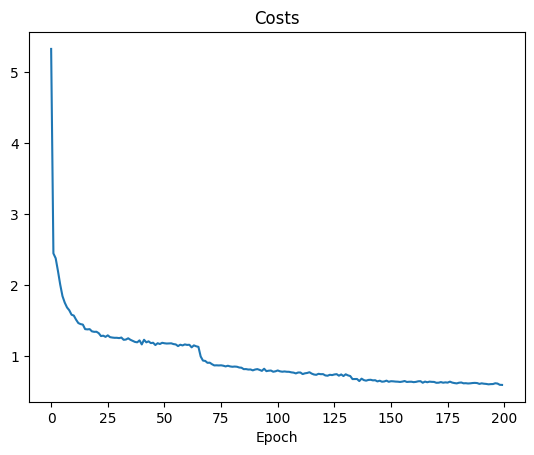

In [8]:
plt.plot(costs)
plt.xlabel("Epoch")
plt.title('Costs')

Text(0.5, 1.0, 'Cross Validation Error Rates')

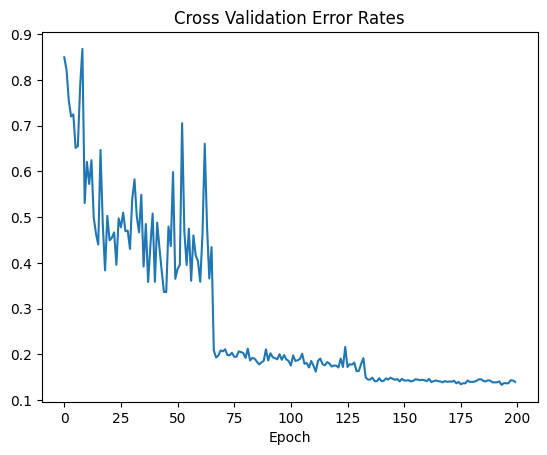

In [9]:
plt.plot(val_error_rates)
plt.xlabel("Epoch")
plt.title('Cross Validation Error Rates')

Text(0.5, 1.0, 'Learning Rates')

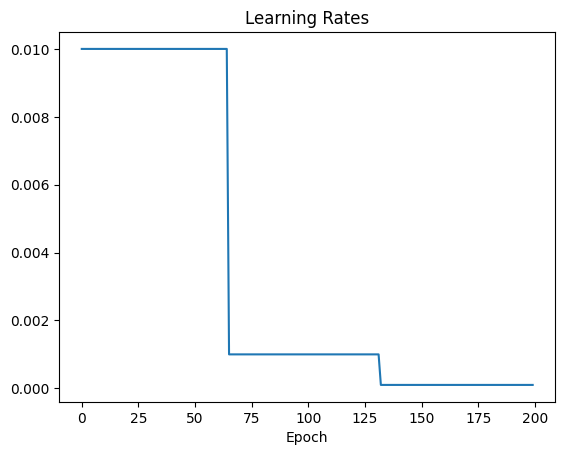

In [10]:
plt.plot(learning_rates)
plt.xlabel("Epoch")
plt.title('Learning Rates')